In [2]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import csv
import os

def run_yolo_inference(model_path, image_path, output_image_path, output_csv_path):
    # Load the YOLO model
    model = YOLO(model_path)

    # Load the image with PIL
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    width, height = img.size
    font = ImageFont.load_default()

    # Run inference on the image
    results = model(image_path)[0]

    # Prepare data for CSV
    csv_data = []

    for result in results:
        # Get the bounding box in xyxy format
        box = result.boxes.xyxy[0]
        x1, y1, x2, y2 = map(int, box)

        # Get the class ID for the detected object
        class_id = int(result.boxes.cls[0])  # Get the class ID as an integer

        # Normalize bounding box values by image width and height
        norm_x1, norm_y1 = x1 / width, y1 / height
        norm_x2, norm_y2 = x2 / width, y2 / height

        # Calculate the center of the bounding box and mark it in red
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
        norm_center_x, norm_center_y = center_x / width, center_y / height

        # Calculate normalized bounding box width and height
        bbox_width, bbox_height = x2 - x1, y2 - y1
        norm_bbox_width, norm_bbox_height = bbox_width / width, bbox_height / height

        # Get keypoints and normalize them
        keypoints = result.keypoints.xy.tolist() if result.keypoints else []
        if keypoints:
            keypoints = [(int(x), int(y)) for x, y in keypoints[0] if x != 0 and y != 0]

            # Normalize keypoints and prepare CSV data for this detection
            row = [class_id, round(norm_center_x, 2), round(norm_center_y, 2), round(norm_bbox_width, 2), round(norm_bbox_height, 2)]
            for x, y in keypoints[:8]:  # Only take the first 8 keypoints
                norm_x, norm_y = round(x / width, 2), round(y / height, 2)
                row.extend([norm_x, norm_y])

            # Trim row to exactly 21 elements (id, 4 bb info, 16 keypoint info)
            row = row[:21]
            csv_data.append(row)

In [10]:
import os
import numpy as np
import pandas as pd
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# Error calculation functions
def calculate_rmse(predicted, actual):
    return np.sqrt(np.mean((predicted - actual) ** 2))

def calculate_mae(predicted, actual):
    return np.mean(np.abs(predicted - actual))

# Paths
image_dir = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\images\val"
ground_truth_2d_dir = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\2d_data"
model_path = 'C:/Users/sakar/mt-3d-environments-from-video/runs/pose/5_objects_and_edges/weights/last.pt'

# Load YOLO model
model = YOLO(model_path)

# Initialize error storage
errors = {}

# Loop through all images in the image directory
for image_file in os.listdir(image_dir):
    if image_file.endswith((".jpg", ".png")):
        image_path = os.path.join(image_dir, image_file)
        ground_truth_2d_path = os.path.join(ground_truth_2d_dir, image_file.replace(".jpg", ".csv").replace(".png", ".csv"))

        # Check if the corresponding 2D CSV exists
        if not os.path.exists(ground_truth_2d_path):
            print(f"Ground truth 2D data for {image_file} not found. Skipping.")
            continue

        # Perform YOLO inference
        results = model(image_path)[0]
        img = Image.open(image_path)
        width, height = img.size

        # Extract predicted points
        predicted_points = []
        for result in results:
            if result.keypoints is not None:
                keypoints = result.keypoints.xy[0].tolist()
                predicted_points.extend([(kp[0] / width, kp[1] / height) for kp in keypoints[:8]])

        # Load ground truth 2D points
        try:
            ground_truth_df = pd.read_csv(ground_truth_2d_path, header=None)
            ground_truth_points = ground_truth_df.iloc[0, 1:].values.reshape(-1, 2)  # Drop ID column
        except Exception as e:
            print(f"Error loading ground truth 2D data for {image_file}: {e}")
            continue

        if len(predicted_points) < 8 or len(ground_truth_points) < 8:
            print(f"Not enough keypoints for {image_file}. Skipping.")
            continue

        predicted_points = np.array(predicted_points[:8])  # Ensure only first 8 points
        ground_truth_points = np.array(ground_truth_points[:8])

        # Split into components
        pred_bb_center = predicted_points[:1, :2]
        gt_bb_center = ground_truth_points[:1, :2]

        pred_bb_size = predicted_points[1:2, :2]
        gt_bb_size = ground_truth_points[1:2, :2]

        pred_corners = predicted_points[2:8, :]
        gt_corners = ground_truth_points[2:8, :]

        # Calculate errors
        rmse_bb_center = calculate_rmse(pred_bb_center, gt_bb_center)
        rmse_bb_size = calculate_rmse(pred_bb_size, gt_bb_size)
        rmse_corners = calculate_rmse(pred_corners, gt_corners)

        mae_bb_center = calculate_mae(pred_bb_center, gt_bb_center)
        mae_bb_size = calculate_mae(pred_bb_size, gt_bb_size)
        mae_corners = calculate_mae(pred_corners, gt_corners)

        total_rmse = rmse_bb_center + rmse_bb_size + rmse_corners
        total_mae = mae_bb_center + mae_bb_size + mae_corners

        errors[image_file] = {
            "RMSE_BB_Center": rmse_bb_center,
            "RMSE_BB_Size": rmse_bb_size,
            "RMSE_Corners": rmse_corners,
            "RMSE_Total": total_rmse,
            "MAE_BB_Center": mae_bb_center,
            "MAE_BB_Size": mae_bb_size,
            "MAE_Corners": mae_corners,
            "MAE_Total": total_mae,
        }



image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\images\val\2400.png: 384x640 2 Chairs, 1 Desk, 1 Monitor, 1 Door, 6 Edges, 197.4ms
Speed: 5.4ms preprocess, 197.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\images\val\2401.png: 384x640 2 Chairs, 1 Desk, 1 Laptop, 1 Monitor, 1 Door, 6 Edges, 188.0ms
Speed: 3.5ms preprocess, 188.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\images\val\2402.png: 384x640 1 Chair, 6 Edges, 172.5ms
Speed: 4.4ms preprocess, 172.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\8_correct_relative\images\val\2403.png: 384x640 1 Chair, 1 Door, 6 Edges, 200.0ms
Speed: 2.2ms preprocess, 200.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

i

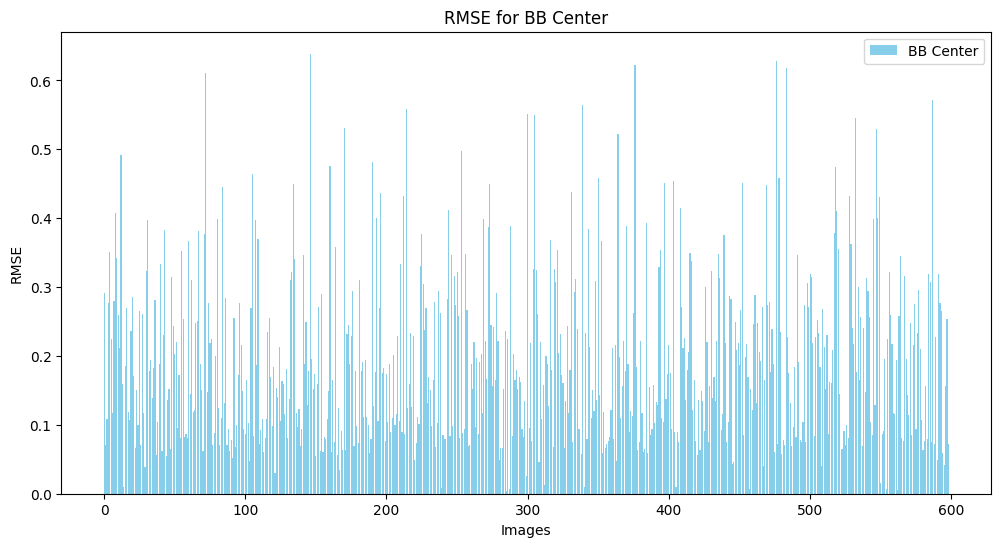

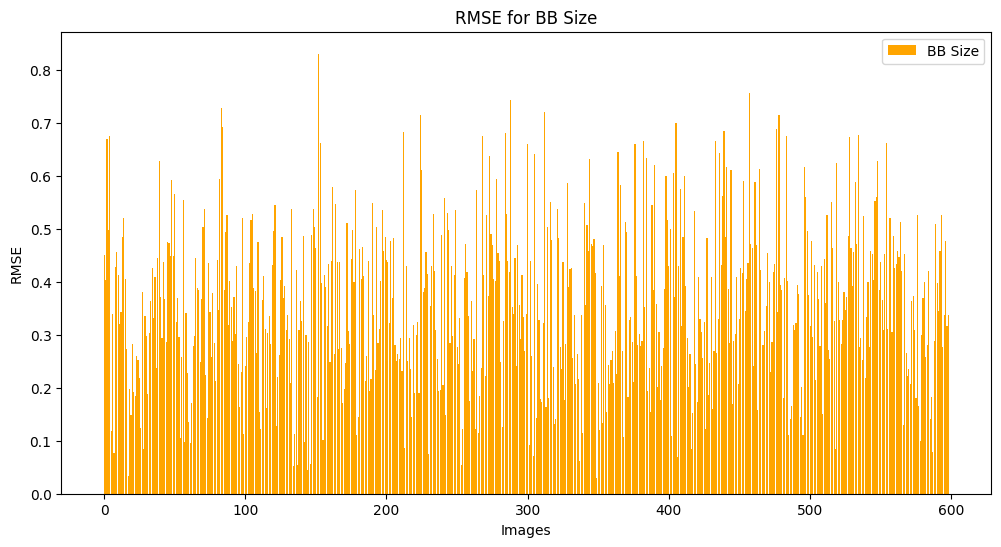

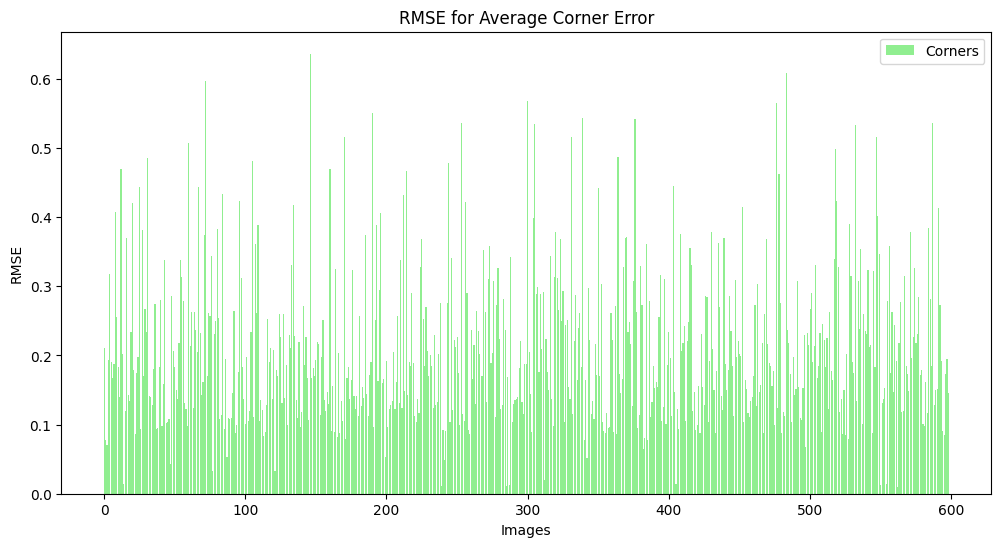

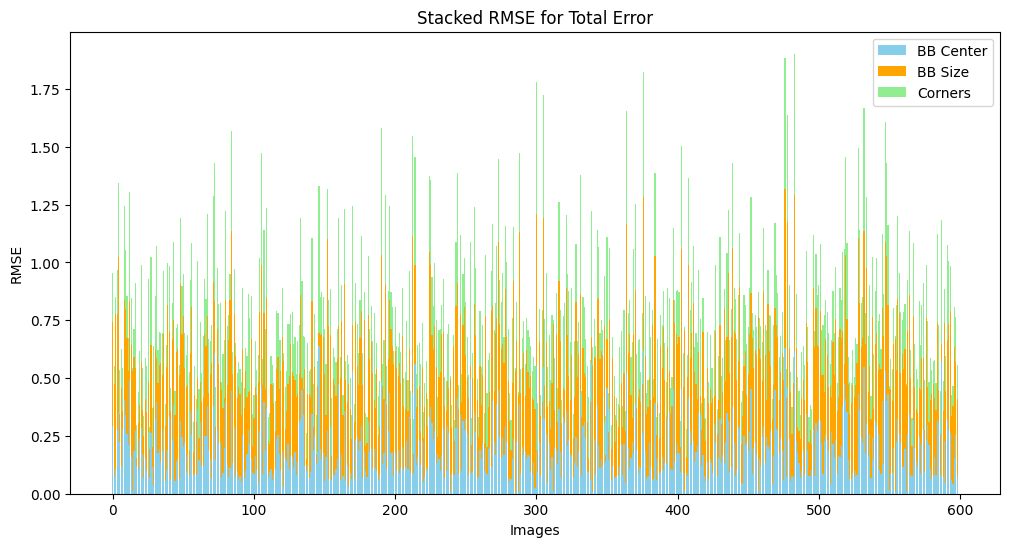

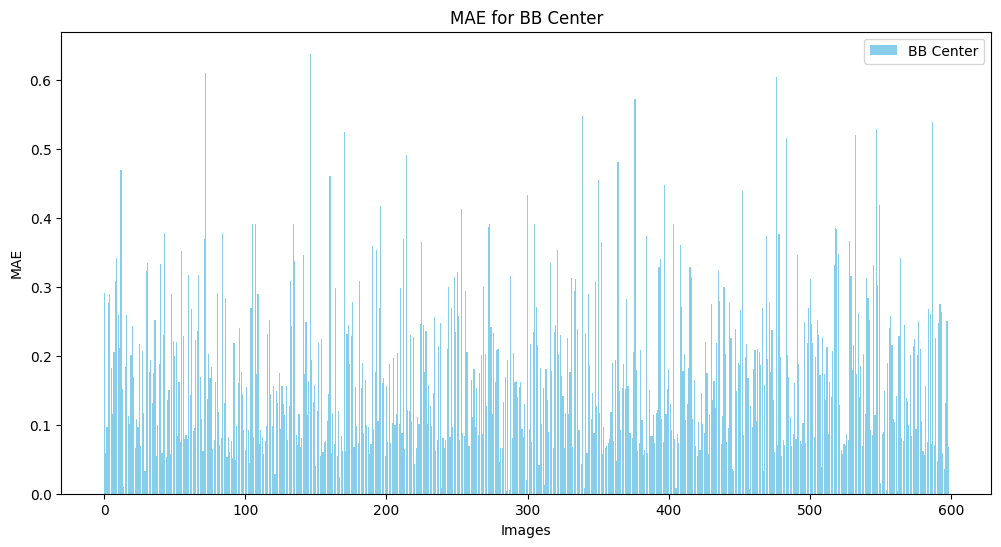

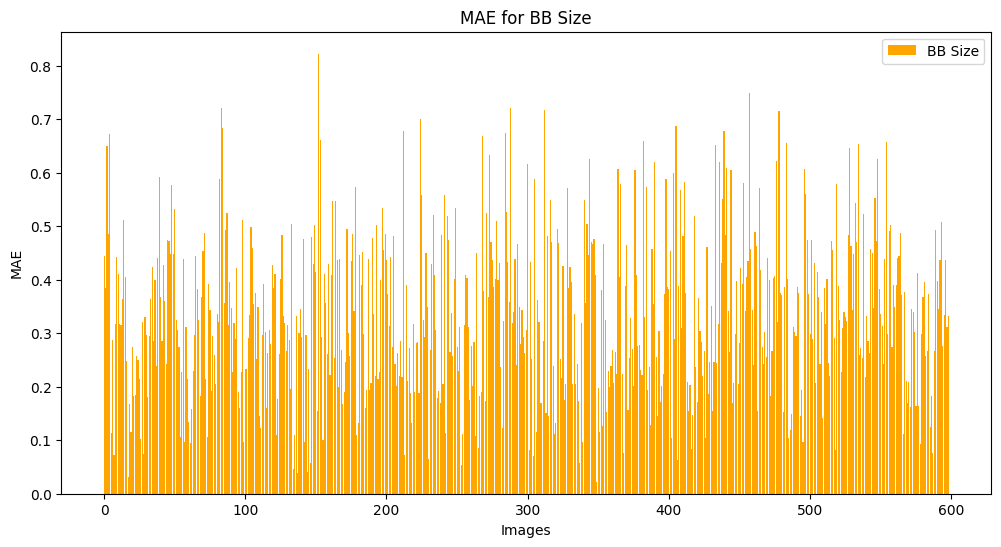

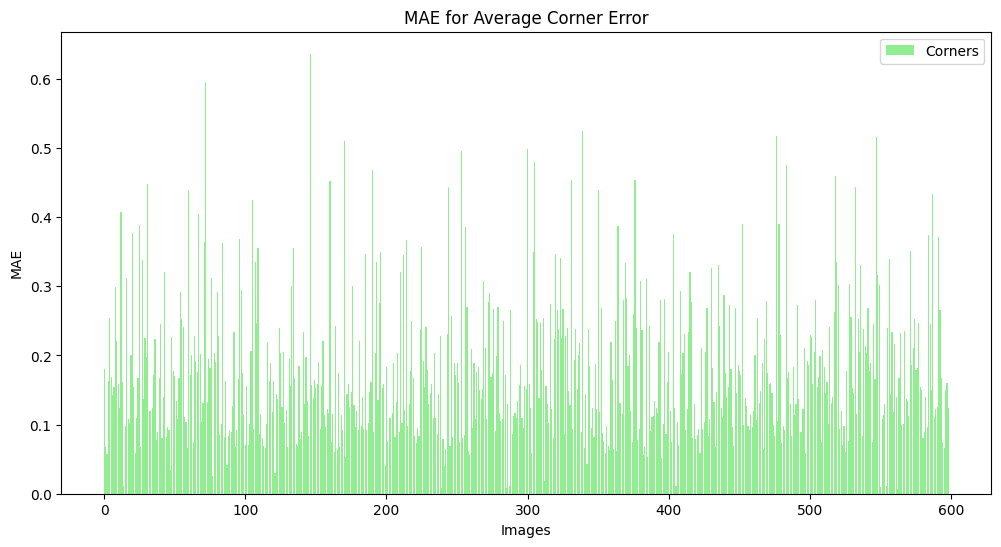

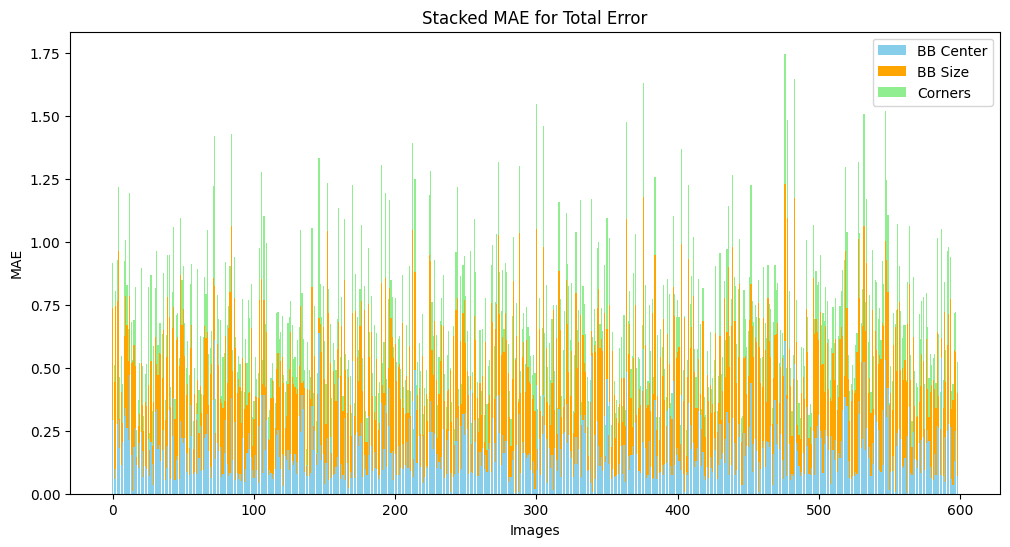

In [14]:
# Visualization
def visualize_errors(errors):
    df = pd.DataFrame.from_dict(errors, orient="index")
    df.index.name = "Image"
    df.reset_index(inplace=True)

    x = np.arange(len(df))

    # Plot RMSE for BB Center
    plt.figure(figsize=(12, 6))
    plt.bar(x, df["RMSE_BB_Center"], color="skyblue", label="BB Center")
    plt.xlabel("Images")
    plt.ylabel("RMSE")
    plt.title("RMSE for BB Center")
    plt.legend()
    plt.show()

    # Plot RMSE for BB Size
    plt.figure(figsize=(12, 6))
    plt.bar(x, df["RMSE_BB_Size"], color="orange", label="BB Size")
    plt.xlabel("Images")
    plt.ylabel("RMSE")
    plt.title("RMSE for BB Size")
    plt.legend()
    plt.show()

    # Plot RMSE for Average Corner Error
    plt.figure(figsize=(12, 6))
    plt.bar(x, df["RMSE_Corners"], color="lightgreen", label="Corners")
    plt.xlabel("Images")
    plt.ylabel("RMSE")
    plt.title("RMSE for Average Corner Error")
    plt.legend()
    plt.show()

    # Plot Stacked RMSE for Total Error
    plt.figure(figsize=(12, 6))
    plt.bar(x, df["RMSE_BB_Center"], label="BB Center", color="skyblue")
    plt.bar(x, df["RMSE_BB_Size"], bottom=df["RMSE_BB_Center"], label="BB Size", color="orange")
    plt.bar(x, df["RMSE_Corners"], bottom=df["RMSE_BB_Center"] + df["RMSE_BB_Size"], label="Corners", color="lightgreen")
    plt.xlabel("Images")
    plt.ylabel("RMSE")
    plt.title("Stacked RMSE for Total Error")
    plt.legend()
    plt.show()

    # Plot MAE for BB Center
    plt.figure(figsize=(12, 6))
    plt.bar(x, df["MAE_BB_Center"], color="skyblue", label="BB Center")
    plt.xlabel("Images")
    plt.ylabel("MAE")
    plt.title("MAE for BB Center")
    plt.legend()
    plt.show()

    # Plot MAE for BB Size
    plt.figure(figsize=(12, 6))
    plt.bar(x, df["MAE_BB_Size"], color="orange", label="BB Size")
    plt.xlabel("Images")
    plt.ylabel("MAE")
    plt.title("MAE for BB Size")
    plt.legend()
    plt.show()

    # Plot MAE for Average Corner Error
    plt.figure(figsize=(12, 6))
    plt.bar(x, df["MAE_Corners"], color="lightgreen", label="Corners")
    plt.xlabel("Images")
    plt.ylabel("MAE")
    plt.title("MAE for Average Corner Error")
    plt.legend()
    plt.show()

    # Plot Stacked MAE for Total Error
    plt.figure(figsize=(12, 6))
    plt.bar(x, df["MAE_BB_Center"], label="BB Center", color="skyblue")
    plt.bar(x, df["MAE_BB_Size"], bottom=df["MAE_BB_Center"], label="BB Size", color="orange")
    plt.bar(x, df["MAE_Corners"], bottom=df["MAE_BB_Center"] + df["MAE_BB_Size"], label="Corners", color="lightgreen")
    plt.xlabel("Images")
    plt.ylabel("MAE")
    plt.title("Stacked MAE for Total Error")
    plt.legend()
    plt.show()

# Call visualization
visualize_errors(errors)